# Data importing

In [ ]:
pip install missingno

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import missingno as msno
from sklearn.preprocessing import LabelEncoder
import plotly.express as px

pd.set_option('display.max_columns', 20)  
pd.set_option('display.max_rows', 30) 

In [2]:
import zipfile
import os

zip_file_path = r'C:\Users\admin\Downloads\train_dataset_train_data_NPF.zip'
extract_to = r'C:\Users\admin\Downloads\train_data' 


with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

csv_file_path = os.path.join(extract_to, 'train_data', 'cntrbtrs_clnts_ops_trn.csv')
csv_file_tranzactions = os.path.join(extract_to, 'train_data', 'trnsctns_ops_trn.csv')



In [3]:
base_data = pd.read_csv(csv_file_path, encoding='windows-1251', sep=';', on_bad_lines='skip')
tranzactions = pd.read_csv(csv_file_tranzactions, encoding='windows-1251', sep=';', on_bad_lines='skip')

data = pd.merge(base_data, tranzactions, on='accnt_id', how='inner')

data.shape

C:\Users\admin\AppData\Local\Temp\ipykernel_15468\2913228199.py:1: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  base_data = pd.read_csv(csv_file_path, encoding='windows-1251', sep=';', on_bad_lines='skip')


(27225905, 30)

# Data exploring

### Primary data exploring

In [4]:
TARGET = "erly_pnsn_flg"
ID = 'accnt_id'

In [ ]:
data.head()

In [ ]:
data.describe()

In [ ]:
data.dtypes

In [ ]:
data.isnull().sum()

In [ ]:
missing_okato_procent = round((int(data.okato.isna().sum()) / data.shape[0]) * 100, 4)
missing_okato_procent

In [ ]:
msno.matrix(data[['dstrct', 'city', 'sttlmnt', 'okato', 'rgn']])

In [ ]:
value_counts = data['erly_pnsn_flg'].value_counts().reset_index()

value_counts.columns = ['erly_pnsn_flg', 'count']

fig = px.pie(value_counts, values='count', names='erly_pnsn_flg')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

Выводы:
1. По причине большого количества пропусков данных в столбцах 'dstrct', 'city', 'sttlmnt' и наличия столбца с ОКАТО, который содержит в своем коде всю необходимую информацию про населенный пункт, можно удалить данные столбцы оставив только ОКАТО и регион, так как именно от региона зависит разница выплаты пенсий, а данные про город и населенный пункт вторичны. Также для отображения местоположения будет оставлен столбец с почтовым индексом.

Структура кода ОКАТО
- республику;
- край;
- область;
- город федерального значения;
- автономную область;
- автономный округ, входящий в состав Российской Федерации.

2. Пустые значения в столбцах ОКАТО и регион можно удалить так как это незначительная часть датасета - всего 0.15% от общего количества.
3. Данные сильно несбалансированы. 

In [ ]:
from scipy.stats import chi2_contingency

# проверка корреляции предидущего НПО и таргета для того, чтобы принять решение о необходимости наличия данной фичи в датасете

def inspect_cat_col_corr(cat_col):
    contingency_table = pd.crosstab(data[cat_col], data[TARGET])

    # Perform Chi-squared test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi2: {chi2}, p-value: {p}")

    # Calculate effect size (Cramér's V)
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    phi2cor = max(0, phi2 - (k - 1) * (r - 1) / (n - 1))
    rcorr = r - (r - 1) ** 2 / (n - 1)
    kcorr = k - (k - 1) ** 2 / (n - 1)
    
    cramers_v = np.sqrt(phi2cor / min((kcorr - 1), (rcorr - 1)))
    print(f"Cramér's V: {cramers_v}")

inspect_cat_col_corr('prvs_npf')


Существует слабая корреляция между прошлым НПО и ранним выходом на пенсию так что данную фичу можно спокойно удалять

In [5]:
binary_columns = ['phn', 'email', 'lk']  

for col in binary_columns:
    data[col] = data[col].replace({'нет': 0, 'да': 1})

data.phn.unique()

C:\Users\admin\AppData\Local\Temp\ipykernel_15468\2683850727.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[col] = data[col].replace({'нет': 0, 'да': 1})


array([0, 1])

In [9]:
numeric_cols = data.select_dtypes(include=['int', 'float']).columns
numeric_cols

Index(['slctn_nmbr', 'brth_yr', 'prsnt_age', 'cprtn_prd_d', 'erly_pnsn_flg',
       'pnsn_age', 'okato', 'phn', 'email', 'lk', 'mvmnt_type', 'sum'],
      dtype='object')

In [7]:
correlation_matrix = data[numeric_cols].corr()

target_correlation = correlation_matrix[TARGET].sort_values(ascending=False)
target_correlation

erly_pnsn_flg    1.000000
cprtn_prd_d      0.703767
brth_yr          0.485112
pnsn_age         0.321240
lk               0.228630
sum              0.185198
mvmnt_type       0.149665
slctn_nmbr       0.073470
email            0.016399
okato            0.005295
phn              0.003927
prsnt_age       -0.485112
Name: erly_pnsn_flg, dtype: float64

### Data cleaning

In [8]:
# убираем дубликаты
data.drop_duplicates() 

,slctn_nmbr,clnt_id,accnt_id,gndr,brth_yr,prsnt_age,accnt_bgn_date,cprtn_prd_d,erly_pnsn_flg,accnt_status,...,phn,email,lk,assgn_npo,assgn_ops,mvmnt_type,sum_type,cmmnt,sum,oprtn_date
0,0,0x03ED62E56DAEA24B96D6F1252D713286,0xFFB14DE2D28AAD45B08AC54ADDFE6AD2,ж,1960,64,2005-12-21,96,0,Накопительный период,...,0,0,0,нет,нет,0.0,Страховые взносы на НЧ,Поступление взносов ОПС,4113.76,2006-02-10
1,0,0x03ED62E56DAEA24B96D6F1252D713286,0xFFB14DE2D28AAD45B08AC54ADDFE6AD2,ж,1960,64,2005-12-21,96,0,Накопительный период,...,0,0,0,нет,нет,0.0,Страховые взносы на НЧ,Поступление взносов ОПС,0.00,2006-06-09
2,0,0x03ED62E56DAEA24B96D6F1252D713286,0xFFB14DE2D28AAD45B08AC54ADDFE6AD2,ж,1960,64,2005-12-21,96,0,Накопительный период,...,0,0,0,нет,нет,0.0,Страховые взносы на НЧ,Поступление взносов ОПС,0.00,2006-11-04
3,0,0x03ED62E56DAEA24B96D6F1252D713286,0xFFB14DE2D28AAD45B08AC54ADDFE6AD2,ж,1960,64,2005-12-21,96,0,Накопительный период,...,0,0,0,нет,нет,0.0,ИД на страховые взносы на НЧ,Распределение ИД ОПС,504.66,2006-11-16
4,0,0x03ED62E56DAEA24B96D6F1252D713286,0xFFB14DE2D28AAD45B08AC54ADDFE6AD2,ж,1960,64,2005-12-21,96,0,Накопительный период,...,0,0,0,нет,нет,0.0,Страховые взносы на НЧ,Поступление взносов ОПС,0.00,2007-06-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27225896,3,0x943D2C768A4FB38311E65E1C6B803110,0x943D2C768A4FB38311E65E1C6B803112,м,1959,65,2010-08-30,204,0,Накопительный период,...,0,0,0,нет,нет,1.0,ИД на страховые взносы на НЧ,Решение о единовременной выплате (ОПС),515.32,2017-07-16
27225897,3,0x943D2C768A4FB38311E65E1C6B803110,0x943D2C768A4FB38311E65E1C6B803112,м,1959,65,2010-08-30,204,0,Накопительный период,...,0,0,0,нет,нет,0.0,ИД на страховые взносы на НЧ,Решение о единовременной выплате (ОПС),515.32,2017-07-16
27225899,3,0x943D2C768A4FB38311E65E1C6B803110,0x943D2C768A4FB38311E65E1C6B803112,м,1959,65,2010-08-30,204,0,Накопительный период,...,0,0,0,нет,нет,0.0,ИД на страховые взносы на НЧ,Распределение ИД ОПС,0.00,2024-01-06
27225901,3,0x943D2C768A4FB38311E65E1C6B803110,0x943D2C768A4FB38311E65E1C6B803112,м,1959,65,2010-08-30,204,0,Накопительный период,...,0,0,0,нет,нет,0.0,ИД на страховые взносы на НЧ,Распределение ИД ОПС,0.00,2024-01-08


In [10]:
data.dropna(subset=['okato', 'rgn'], inplace=True)

In [11]:
useless_columns = ['clnt_id', 'dstrct', 'city', 'sttlmnt', 'prvs_npf']
data.drop(columns=useless_columns, inplace=True)

### Treating outliers

In [12]:
def detect_outliers_iqr(df):
    outlier_columns = []  # List to store column names with outliers
    for column in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Check for outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        
        if not outliers.empty:  
            outlier_columns.append(column)
            print(f"Outliers detected in '{column}': {len(outliers)} outliers detected.")
        
    return outlier_columns 

outlier_features = detect_outliers_iqr(data)
print("Columns with outliers:", outlier_features)


Outliers detected in 'brth_yr': 401085 outliers detected.
Outliers detected in 'prsnt_age': 401085 outliers detected.
Outliers detected in 'cprtn_prd_d': 1895761 outliers detected.
Outliers detected in 'erly_pnsn_flg': 1111697 outliers detected.
Outliers detected in 'phn': 253025 outliers detected.
Outliers detected in 'email': 31389 outliers detected.
Outliers detected in 'lk': 5200258 outliers detected.
Outliers detected in 'mvmnt_type': 2901187 outliers detected.
Outliers detected in 'sum': 5272196 outliers detected.
Columns with outliers: ['brth_yr', 'prsnt_age', 'cprtn_prd_d', 'erly_pnsn_flg', 'phn', 'email', 'lk', 'mvmnt_type', 'sum']


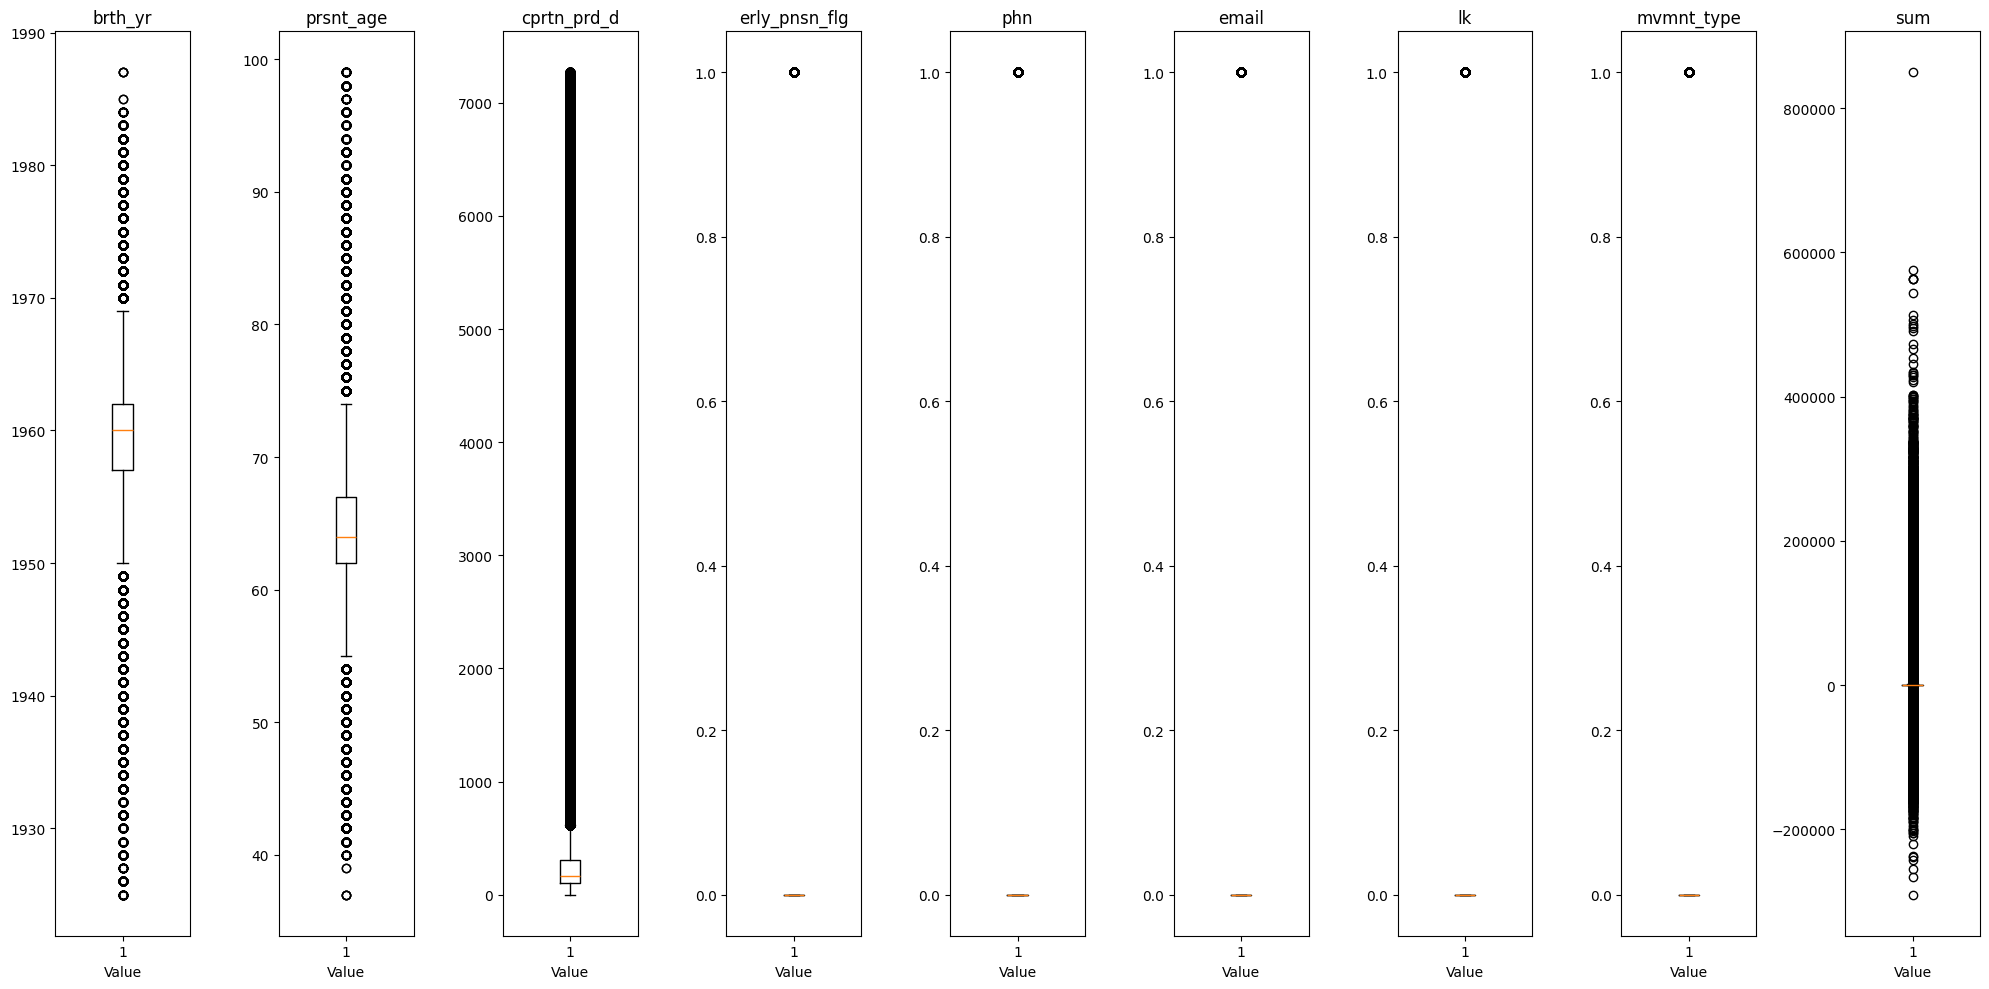

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def plot_boxplots(df, outlier_features):
    plt.figure(figsize=(20, 10))
    
    for i, column in enumerate(outlier_features):
        if column in df.columns:  # Check if the column exists in the DataFrame
            plt.subplot(1, len(outlier_features), i + 1)
            plt.boxplot(df[column])
            plt.title(column)
            plt.xlabel('Value')
    
    plt.tight_layout()
    plt.show()

# Example usage
plot_boxplots(data, outlier_features)

### Treating outliers

In [14]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [17]:
from sklearn.preprocessing import PowerTransformer

def transform_outliers(df, columns):
    for col in columns:
        df[col] = np.where(
            df[col] > 0, 
            np.sqrt(np.log1p(df[col])),  
            df[col]  
        )
    pt = PowerTransformer(method='yeo-johnson')
    transformed_data = pt.fit_transform(df[columns])
    
    df[columns] = transformed_data
    
    return df

In [18]:
train = transform_outliers(train, outlier_features)
test = transform_outliers(test, outlier_features)

C:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


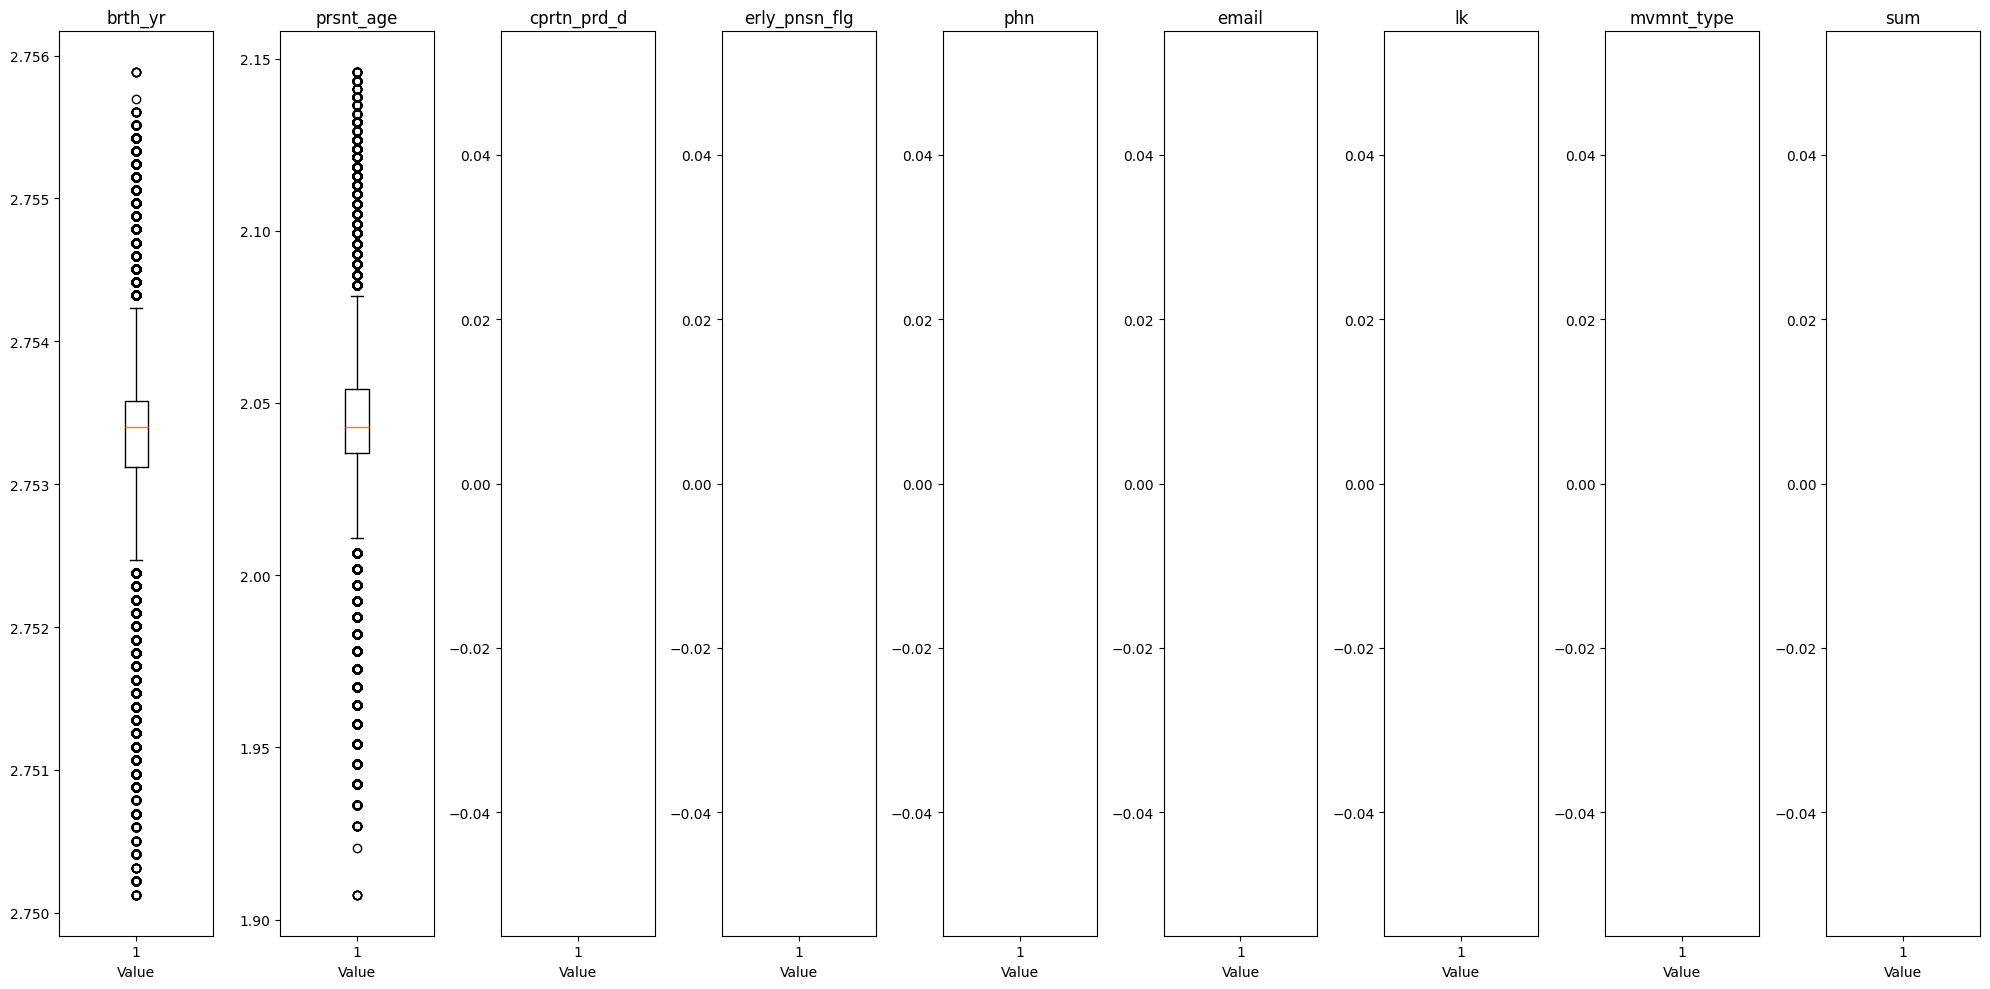

In [17]:
plot_boxplots(train, outlier_features)

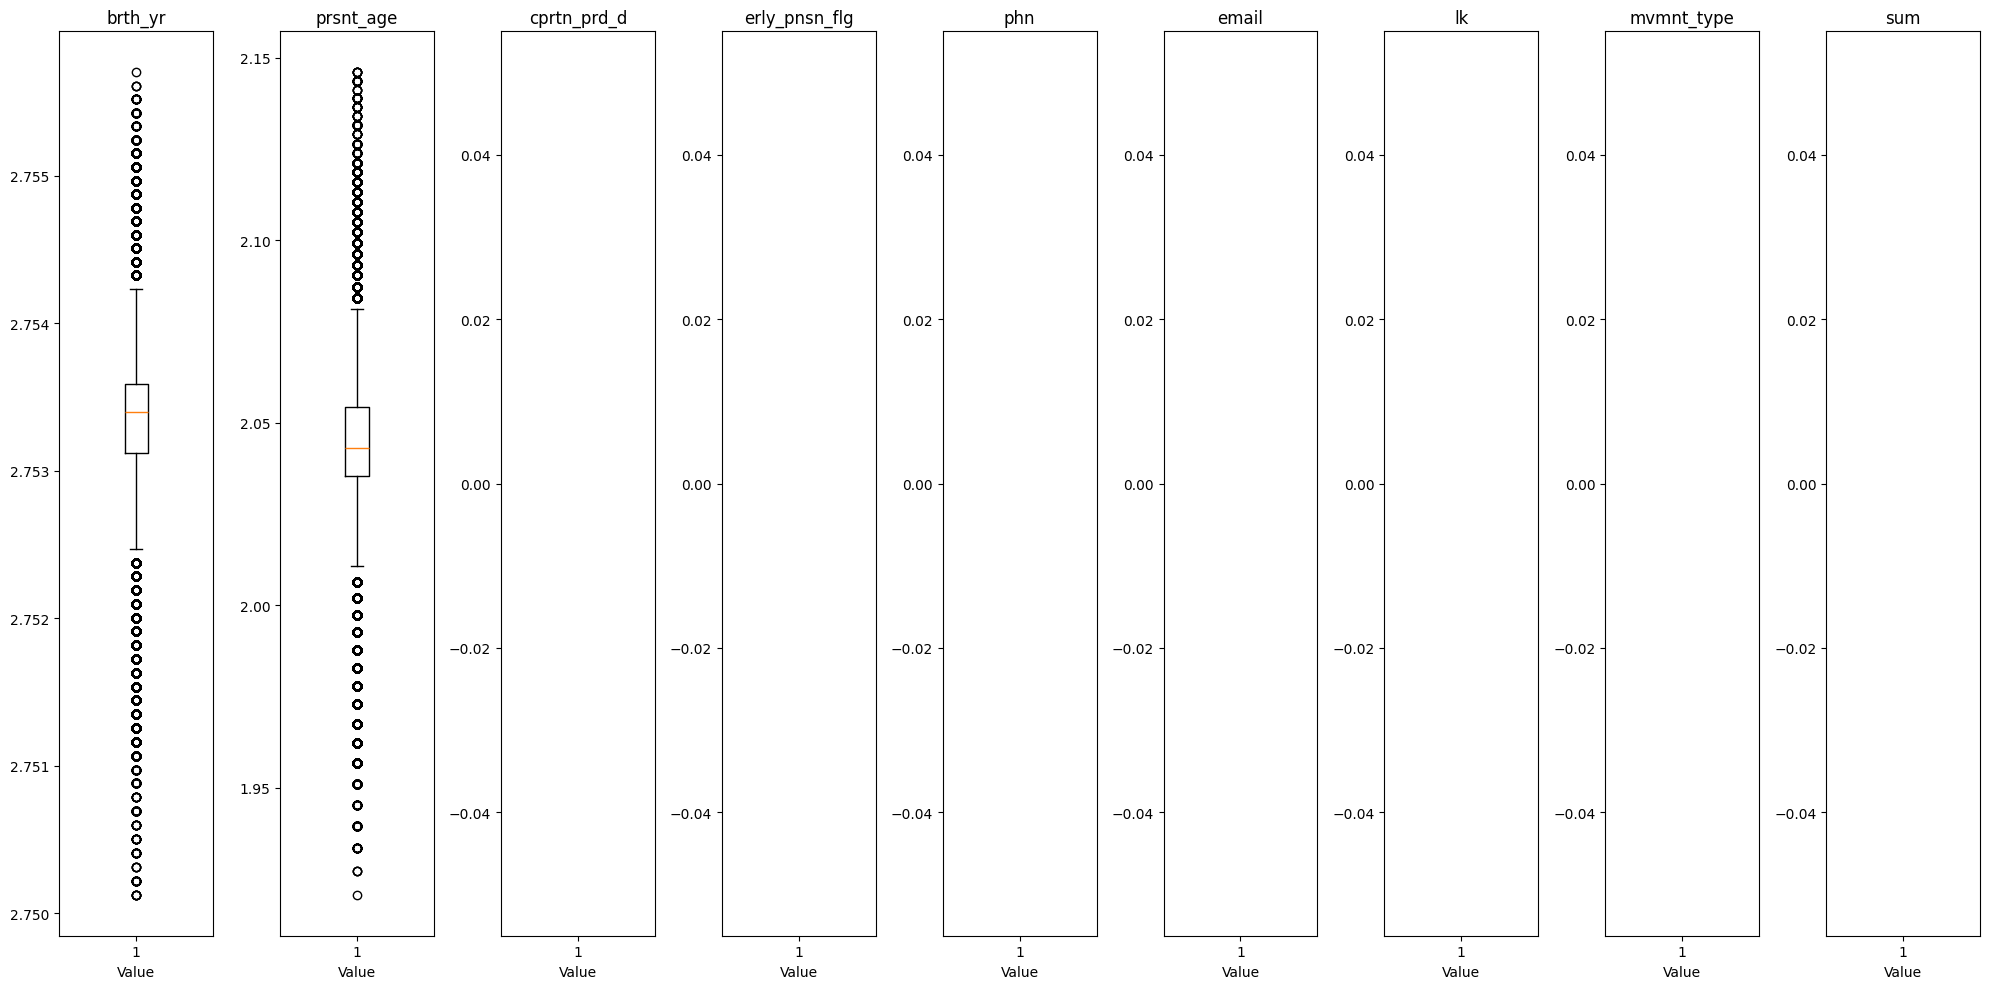

In [18]:
plot_boxplots(test, outlier_features)

### Label encoding

In [19]:
cat_cols = data.select_dtypes(include=['object']).columns
data[cat_cols]

,accnt_id,gndr,accnt_bgn_date,accnt_status,brth_plc,addrss_type,rgn,pstl_code,assgn_npo,assgn_ops,sum_type,cmmnt,oprtn_date
0,0xFFB14DE2D28AAD45B08AC54ADDFE6AD2,ж,2005-12-21,Накопительный период,"1,ГОР. НОВОСИБИРСК",Адрес места жительства,ОМСКАЯ ОБЛ,644001,нет,нет,Страховые взносы на НЧ,Поступление взносов ОПС,2006-02-10
1,0xFFB14DE2D28AAD45B08AC54ADDFE6AD2,ж,2005-12-21,Накопительный период,"1,ГОР. НОВОСИБИРСК",Адрес места жительства,ОМСКАЯ ОБЛ,644001,нет,нет,Страховые взносы на НЧ,Поступление взносов ОПС,2006-06-09
2,0xFFB14DE2D28AAD45B08AC54ADDFE6AD2,ж,2005-12-21,Накопительный период,"1,ГОР. НОВОСИБИРСК",Адрес места жительства,ОМСКАЯ ОБЛ,644001,нет,нет,Страховые взносы на НЧ,Поступление взносов ОПС,2006-11-04
3,0xFFB14DE2D28AAD45B08AC54ADDFE6AD2,ж,2005-12-21,Накопительный период,"1,ГОР. НОВОСИБИРСК",Адрес места жительства,ОМСКАЯ ОБЛ,644001,нет,нет,ИД на страховые взносы на НЧ,Распределение ИД ОПС,2006-11-16
4,0xFFB14DE2D28AAD45B08AC54ADDFE6AD2,ж,2005-12-21,Накопительный период,"1,ГОР. НОВОСИБИРСК",Адрес места жительства,ОМСКАЯ ОБЛ,644001,нет,нет,Страховые взносы на НЧ,Поступление взносов ОПС,2007-06-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27225900,0x943D2C768A4FB38311E65E1C6B803112,м,2010-08-30,Накопительный период,"1,КРАСНОЯРСК,,,",Адрес места жительства,КРАСНОЯРСКИЙ КРАЙ,660064,нет,нет,ИД на страховые взносы на НЧ,Распределение ИД ОПС,2024-01-06
27225901,0x943D2C768A4FB38311E65E1C6B803112,м,2010-08-30,Накопительный период,"1,КРАСНОЯРСК,,,",Адрес места жительства,КРАСНОЯРСКИЙ КРАЙ,660064,нет,нет,ИД на страховые взносы на НЧ,Распределение ИД ОПС,2024-01-08
27225902,0x943D2C768A4FB38311E65E1C6B803112,м,2010-08-30,Накопительный период,"1,КРАСНОЯРСК,,,",Адрес места жительства,КРАСНОЯРСКИЙ КРАЙ,660064,нет,нет,ИД на страховые взносы на НЧ,Распределение ИД ОПС,2024-01-08
27225903,0x943D2C768A4FB38311E65E1C6B803112,м,2010-08-30,Накопительный период,"1,КРАСНОЯРСК,,,",Адрес места жительства,КРАСНОЯРСКИЙ КРАЙ,660064,нет,нет,ИД на страховые взносы на НЧ,Распределение ИД ОПС,2024-01-14


In [22]:
def label_encode(df, cols):
    label_encoder = LabelEncoder()
    for col in cols:
        df[col] = label_encoder.fit_transform(df[col].astype(str))
    return df

train = label_encode(train, cat_cols)
test = label_encode(test, cat_cols)

In [23]:
train.isnull().sum()

slctn_nmbr        0
accnt_id          0
gndr              0
brth_yr           0
prsnt_age         0
accnt_bgn_date    0
cprtn_prd_d       0
erly_pnsn_flg     0
accnt_status      0
pnsn_age          0
brth_plc          0
addrss_type       0
rgn               0
pstl_code         0
okato             0
phn               0
email             0
lk                0
assgn_npo         0
assgn_ops         0
mvmnt_type        0
sum_type          0
cmmnt             0
sum               0
oprtn_date        0
dtype: int64

In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21748362 entries, 499826 to 23234793
Data columns (total 25 columns):
 #   Column          Dtype  
---  ------          -----  
 0   slctn_nmbr      int64  
 1   accnt_id        int64  
 2   gndr            int64  
 3   brth_yr         float64
 4   prsnt_age       float64
 5   accnt_bgn_date  int64  
 6   cprtn_prd_d     float64
 7   erly_pnsn_flg   float64
 8   accnt_status    int64  
 9   pnsn_age        int64  
 10  brth_plc        int64  
 11  addrss_type     int64  
 12  rgn             int64  
 13  pstl_code       int64  
 14  okato           float64
 15  phn             float64
 16  email           float64
 17  lk              float64
 18  assgn_npo       int64  
 19  assgn_ops       int64  
 20  mvmnt_type      float64
 21  sum_type        int64  
 22  cmmnt           int64  
 23  sum             float64
 24  oprtn_date      int64  
dtypes: float64(10), int64(15)
memory usage: 4.2 GB


### Normalizing

In [27]:
X_train = train.drop(TARGET, axis=1)
X_test = test.drop(TARGET, axis=1)

y_train = train[TARGET]
y_test = test[TARGET]

In [28]:
from sklearn.preprocessing import RobustScaler


def apply_scaler(df, target_column):
    scaler = RobustScaler()
    columns = [col for col in df.columns if col != target_column]
    scaled_data = scaler.fit_transform(df[columns])
    df_scaled = pd.DataFrame(scaled_data, columns=columns)
    df_scaled[target_column] = df[target_column].reset_index(drop=True)
    
    return df_scaled

X_train = apply_scaler(train, TARGET)

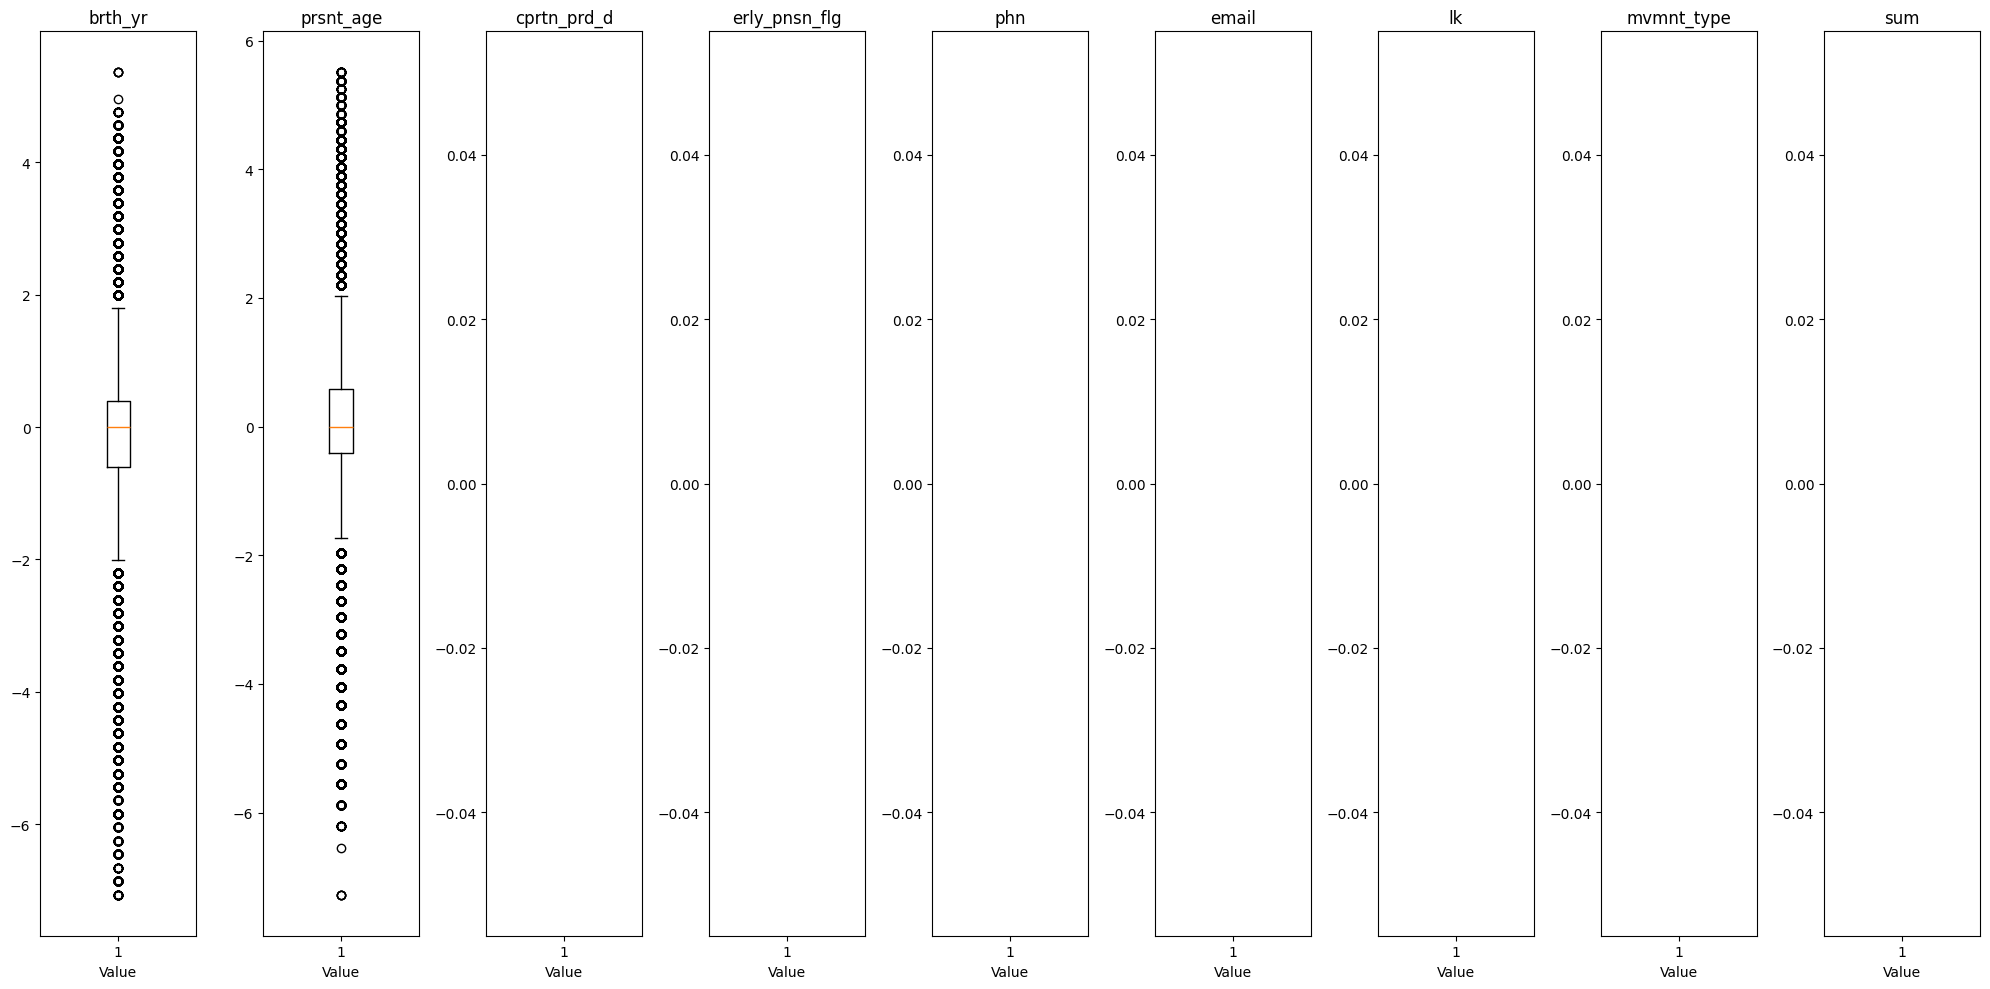

In [24]:
plot_boxplots(train, outlier_features)

### Oversampling

In [29]:
X_train.isnull().sum()

slctn_nmbr        0
accnt_id          0
gndr              0
brth_yr           0
prsnt_age         0
accnt_bgn_date    0
cprtn_prd_d       0
accnt_status      0
pnsn_age          0
brth_plc          0
addrss_type       0
rgn               0
pstl_code         0
okato             0
phn               0
email             0
lk                0
assgn_npo         0
assgn_ops         0
mvmnt_type        0
sum_type          0
cmmnt             0
sum               0
oprtn_date        0
erly_pnsn_flg     0
dtype: int64

In [33]:
lab_enc = LabelEncoder()
y_train = lab_enc.fit_transform(y_train)

In [34]:
from imblearn.over_sampling import SMOTE

def resample(X, y):
    smote = SMOTE(sampling_strategy='auto', random_state=42)

    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    return X_resampled, y_resampled

X_train, y_train = resample(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
whole_train = pd.concat([X_train, y_train], axis=1)
whole_train.columns

In [ ]:
figure, axis = plt.subplots(1, 3, figsize=(8, 3))
figure.tight_layout(pad=2.5)


sns.countplot(x='HeartDisease', data=whole_train, palette=['green', 'red'], ax=axis[1])
axis[1].set_title('HeartDisease')

plt.show()

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error

base_models = [
    ('decision_tree', DecisionTreeRegressor(random_state=42)),
    ('linear_regression', LinearRegression())
]

stacked_model = StackingRegressor(estimators=base_models, final_estimator=LinearRegression())

stacked_model.fit(X_train, y_train)

y_pred = stacked_model.predict(X_test) 

In [ ]:
results = pd.DataFrame(
    {'prediction': y_pred}
)
results

In [ ]:
results.to_csv('predictions')